In [11]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [12]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            key = f"sub_exp_cfg_{key.strip()}"  # Add prefix
            variables[key] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [13]:
experiment_sub_dir = "2025Mar16-134623_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.lr', 'sub_exp_cfg_agent_params.args_.gamma',
       'sub_exp_cfg_agent_params.args_.training_freq', 'seed',
       'experiment_name'],
      dtype='object')

In [14]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.gamma,sub_exp_cfg_agent_params.args_.training_freq,seed,experiment_name
0,training,200000,-317.471927,-47.570700,-305.347801,-317.471927,54.385374,-32.420891,-19.667888,-31.953064,...,-6.323567,2.011901,194999.0,48.0,0 days 00:10:13.074728,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
1,training,400000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-32.420891,-32.420891,-32.420891,...,-7.515750,0.128182,200000.0,50.0,0 days 00:12:06.119242,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
2,training,600000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-32.420891,-32.420891,-32.420891,...,-7.750363,0.083233,200000.0,50.0,0 days 00:12:22.842007,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
3,training,800000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-32.420891,-32.420891,-32.420891,...,-7.858598,0.021475,200000.0,50.0,0 days 00:12:48.681262,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
4,training,1000000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-32.420891,-32.420891,-32.420891,...,-7.873897,0.012824,200000.0,50.0,0 days 00:13:00.667908,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,training,400000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-63.822808,-63.822808,-63.822808,...,-14.172870,0.342668,200000.0,50.0,0 days 00:11:34.140009,0.1,0.95,1,1,0002_optim.args_.lr_0.1__agent_params.args_.ga...
180,training,600000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-63.822808,-63.822808,-63.822808,...,-14.523619,0.446202,200000.0,50.0,0 days 00:12:20.969785,0.1,0.95,1,1,0002_optim.args_.lr_0.1__agent_params.args_.ga...
181,validation,200000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-63.822808,-63.822808,-63.822808,...,-13.002199,0.000422,NaN,NaN,0 days 00:00:03.638543,0.1,0.95,1,1,0002_optim.args_.lr_0.1__agent_params.args_.ga...
182,validation,400000,-317.471927,-317.471927,-317.471927,-317.471927,0.000000,-63.822808,-63.822808,-63.822808,...,-14.181994,0.000130,NaN,NaN,0 days 00:00:03.405072,0.1,0.95,1,1,0002_optim.args_.lr_0.1__agent_params.args_.ga...


In [15]:
# normalize rewards?

In [16]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.gamma,sub_exp_cfg_agent_params.args_.training_freq,seed,experiment_name
18,validation,200000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-32.420891,-32.420891,-32.420891,...,-7.161294,0.000636,NaN,NaN,0 days 00:00:03.351218,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
19,validation,400000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-32.420891,-32.420891,-32.420891,...,-7.561716,0.001353,NaN,NaN,0 days 00:00:03.877102,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
20,validation,600000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-32.420891,-32.420891,-32.420891,...,-7.838940,0.000437,NaN,NaN,0 days 00:00:03.287423,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
21,validation,800000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-32.420891,-32.420891,-32.420891,...,-7.864784,0.000301,NaN,NaN,0 days 00:00:03.181650,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
22,validation,1000000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-32.420891,-32.420891,-32.420891,...,-7.867583,0.000527,NaN,NaN,0 days 00:00:03.272211,0.1,0.9,1,0,0000_optim.args_.lr_0.1__agent_params.args_.ga...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,validation,400000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-63.822808,-63.822808,-63.822808,...,-15.053033,0.000805,NaN,NaN,0 days 00:00:03.380167,0.1,0.95,1,0,0002_optim.args_.lr_0.1__agent_params.args_.ga...
177,validation,600000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-63.822808,-63.822808,-63.822808,...,-15.604096,0.000187,NaN,NaN,0 days 00:00:03.997641,0.1,0.95,1,0,0002_optim.args_.lr_0.1__agent_params.args_.ga...
181,validation,200000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-63.822808,-63.822808,-63.822808,...,-13.002199,0.000422,NaN,NaN,0 days 00:00:03.638543,0.1,0.95,1,1,0002_optim.args_.lr_0.1__agent_params.args_.ga...
182,validation,400000,-317.471927,-317.471927,-317.471927,-317.471927,0.0,-63.822808,-63.822808,-63.822808,...,-14.181994,0.000130,NaN,NaN,0 days 00:00:03.405072,0.1,0.95,1,1,0002_optim.args_.lr_0.1__agent_params.args_.ga...


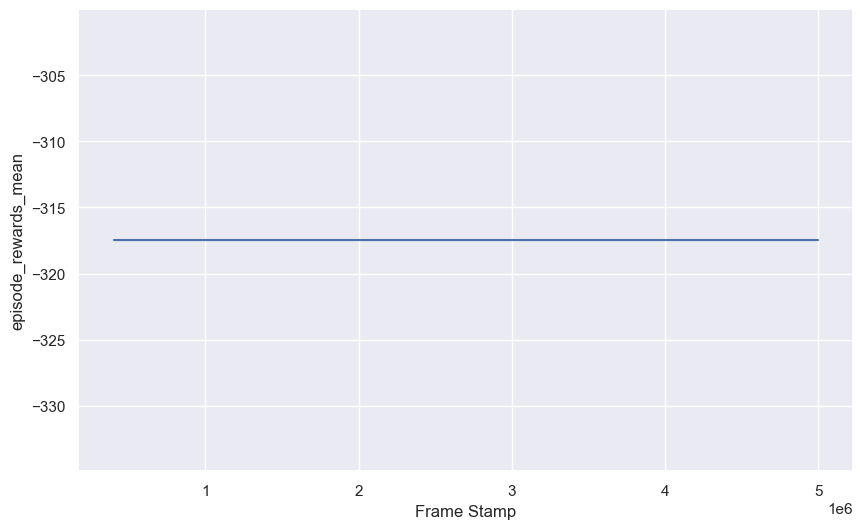

In [17]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

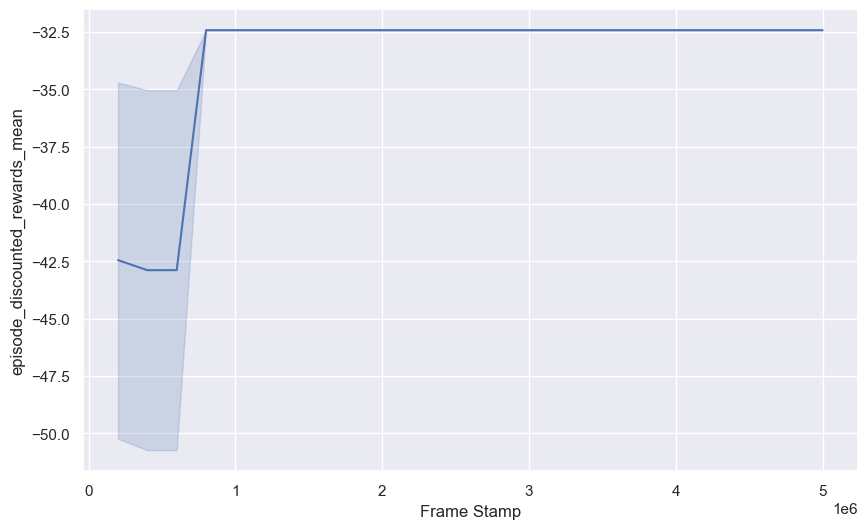

In [18]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [19]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name'
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.gamma,sub_exp_cfg_agent_params.args_.training_freq
121,validation,5000000,-317.471927,100.0,NaN,NaN,0 days 00:00:03.416974,0,0001_optim.args_.lr_0.1__agent_params.args_.ga...,0.1,0.9,2
171,validation,5000000,-317.471927,100.0,NaN,NaN,0 days 00:00:03.438318,1,0001_optim.args_.lr_0.1__agent_params.args_.ga...,0.1,0.9,2


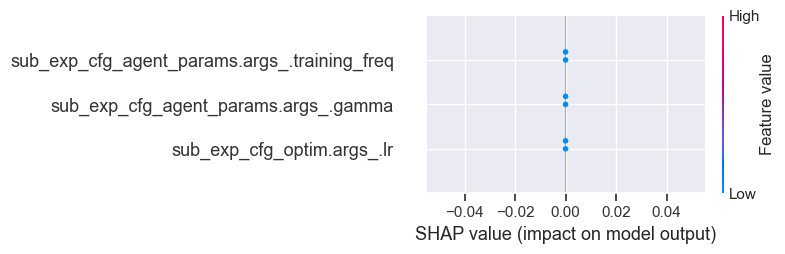

In [20]:
import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)